**Part 1- Feature extraction**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import tensorflow as tf
import os
import pandas as pd
import matplotlib.patches as patches
from collections import defaultdict
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  base path for images and annotation files
base_image_path = '/content/drive/MyDrive/Vision/Project/dataset/'
annotations_base_path = '/content/drive/MyDrive/Vision/Project/dataset/'


# Function to load and preprocess images from a given folder
def load_and_preprocess_images(image_folder, annotation_file):
    annotations = pd.read_csv(annotation_file)
    images = {}
    bboxes = defaultdict(list)
    labels = defaultdict(list)
    scale_factor = 300 / 640  # resizing from 640x640 to 300x300

    for _, row in annotations.iterrows():
        filename = row['filename']
        image_path = os.path.join(image_folder, filename)
        if filename not in images:
            if os.path.exists(image_path):
                image = cv2.imread(image_path)
                image = cv2.resize(image, (300, 300))  # Resizing the image
                images[filename] = image
            else:
                print(f"Image {filename} not found.")
                continue

        # Scale bounding box coordinates
        xmin = int(row['xmin'] * scale_factor)
        ymin = int(row['ymin'] * scale_factor)
        xmax = int(row['xmax'] * scale_factor)
        ymax = int(row['ymax'] * scale_factor)
        bbox = [xmin, ymin, xmax, ymax]

        bboxes[filename].append(bbox)
        labels[filename].append(row['class'])

    # Convert the defaultdicts to lists
    images_list = list(images.values())
    bboxes_list = [bboxes[filename] for filename in images]
    labels_list = [labels[filename] for filename in images]

    return images_list, bboxes_list, labels_list

train_images, train_bboxes, train_labels = load_and_preprocess_images(
    os.path.join(base_image_path, 'train'),
    os.path.join(annotations_base_path, 'train/_annotations.csv')
)

test_images, test_bboxes, test_labels = load_and_preprocess_images(
    os.path.join(base_image_path, 'test'),
    os.path.join(annotations_base_path, 'test/_annotations.csv')
)

valid_images, valid_bboxes, valid_labels = load_and_preprocess_images(
    os.path.join(base_image_path, 'valid'),
    os.path.join(annotations_base_path, 'valid/_annotations.csv')
)

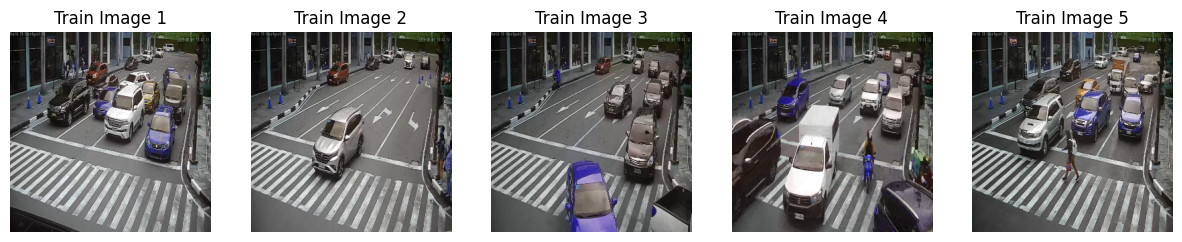

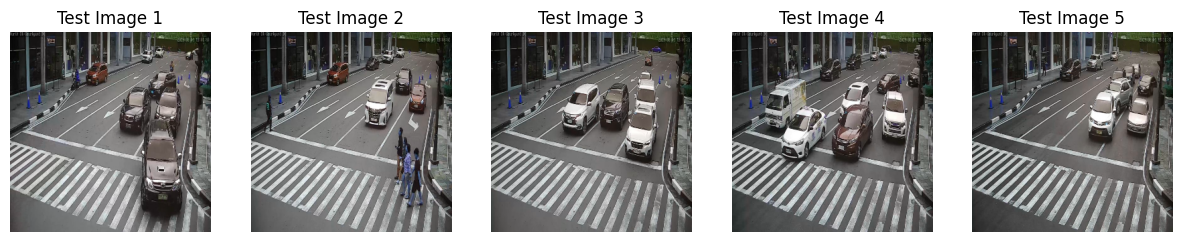

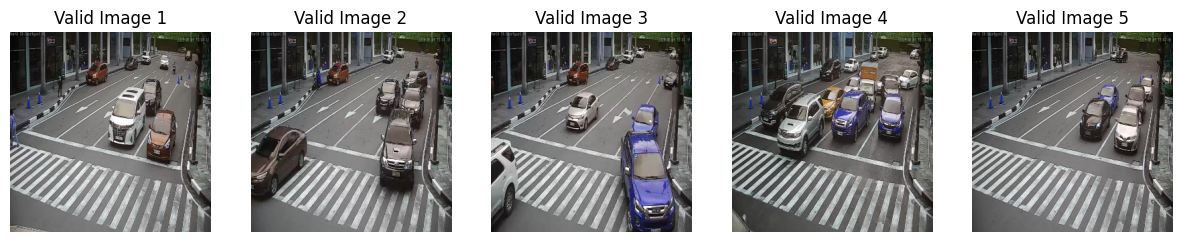

In [ ]:
import matplotlib.pyplot as plt


def display_images(images, title):
    plt.figure(figsize=(15, 3))
    for i in range(min(5, len(images))):  # Display only the first 5 images
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

# Display the first five images from each dataset
display_images(train_images, "Train Image")
display_images(test_images, "Test Image")
display_images(valid_images, "Valid Image")

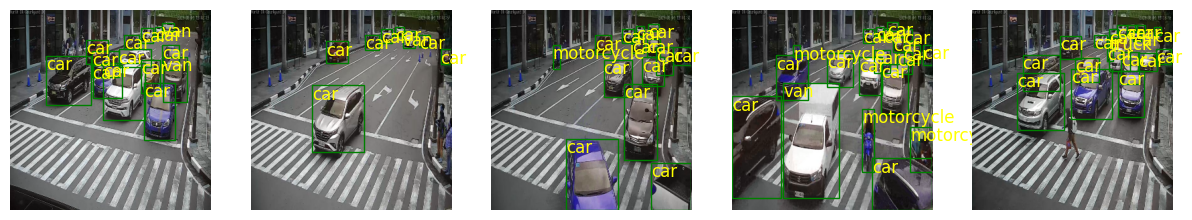

In [ ]:
# Function to display images with bounding boxes
def display_row_of_images_with_bboxes(image_list, bbox_list, label_list, num_samples=5):

    num_samples = min(num_samples, len(image_list))
    plt.figure(figsize=(num_samples * 3, 3))

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image_list[i])
        plt.axis('off')

        # Draw all bounding boxes for the current image
        for bbox, label in zip(bbox_list[i], label_list[i]):
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                linewidth=1, edgecolor='g', facecolor='none'
            )
            ax.add_patch(rect)
            plt.text(bbox[0], bbox[1], label, color='yellow', fontsize=12, verticalalignment='top')

    plt.show()

# Call the function with any of the datasets
display_row_of_images_with_bboxes(train_images, train_bboxes, train_labels)

Try different approach here

In [ ]:
!pip --quiet install tf_slim
!git clone --depth 1 https://github.com/tensorflow/models
!pip --quiet install cython pillow lxml matplotlib pandas contextlib2 tf-slim
!pip --quiet install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

Cloning into 'models'...
remote: Enumerating objects: 4065, done.
remote: Counting objects: 100% (4065/4065), done.
remote: Compressing objects: 100% (3090/3090), done.
remote: Total 4065 (delta 1186), reused 1949 (delta 915), pack-reused 0
Receiving objects: 100% (4065/4065), 54.71 MiB | 14.77 MiB/s, done.
Resolving deltas: 100% (1186/1186), done.
Updating files: 100% (3677/3677), done.
  Preparing metadata (setup.py) ... done


In [ ]:
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
os.environ['PYTHONPATH'] += ':/content/models/research:/content/models/research/slim'

/content/models/research


In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

2023-12-10 21:27:35.782801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/models/research/object_detection/builders/model_builder_tf2_test.py", line 24, in <module>
    from object_detection.builders import model_builder
  File "/content/models/research/object_detection/builders/model_builder.py", line 37, in <module>
    from object_detection.meta_architectures import deepmac_meta_arch
  File "/content/models/research/object_detection/meta_architectures/deepmac_meta_arch.py", line 28, in <module>
    import tensorflow_io as tfio  # pylint:disable=g-import-not-at-top
ModuleNotFoundError: No module named 'tensorflow_io'


In [ ]:
import urllib.request
import tarfile
from object_detection.utils import config_util


MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
MODEL_DATE = '20200711'
MODEL_URL = f'http://download.tensorflow.org/models/object_detection/tf2/{MODEL_DATE}/{MODEL_NAME}.tar.gz'


model_tar = tf.keras.utils.get_file(fname=MODEL_NAME + '.tar.gz',
                                    origin=MODEL_URL,
                                    untar=False)

# Extract the model
if not os.path.isdir(model_tar.replace('.tar.gz', '')):
    with tarfile.open(model_tar, "r:gz") as tar:
        tar.extractall(path=os.path.dirname(model_tar))

model_dir = model_tar.replace('.tar.gz', '')

# Set the path to the pipeline config file
pipeline_config_path = os.path.join(model_dir, 'pipeline.config')

# Load the pipeline config file
configs = config_util.get_configs_from_pipeline_file(pipeline_config_path)

print(f"Model {MODEL_NAME} downloaded and unpacked successfully.")

20515344/20515344 [==============================] - 0s 0us/step
Model ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 downloaded and unpacked successfully.


Shaping the data to feed the algorithm

In [ ]:
label_map = """
item {
  id: 1
  name: 'car'
}
item {
  id: 2
  name: 'van'
}
item {
  id: 3
  name: 'motorcycle'
}
item {
  id: 4
  name: 'truck'
}
item {
  id: 5
  name: 'jeepney'
}
item {
  id: 6
  name: 'bus'
}
item {
  id: 7
  name: 'tricycle'
}
"""

# Save the label map
with open("/content/label_map.pbtxt", "w") as file:
    file.write(label_map)

In [ ]:
# /content/label_map.pbtxt

from object_detection.utils import label_map_util

# Path to the label map file
label_map_path = '/content/label_map.pbtxt'

# Create the label map dictionary
label_map_dict = label_map_util.get_label_map_dict(label_map_path)

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [ ]:
!pip --quiet install tf_slim
!git --quiet clone --depth 1 https://github.com/tensorflow/models
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip --quiet install .

unknown option: --quiet
usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | -P | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           [--super-prefix=<path>] [--config-env=<name>=<envvar>]
           <command> [<args>]
/content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00


In [ ]:
import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util, label_map_util

def create_tf_example(image, bboxes, labels, label_map):
    # Convert the ndarray image to bytes
    image_encoded = tf.io.encode_jpeg(tf.constant(image)).numpy()

    # Image shape
    height, width, _ = image.shape

    xmins, xmaxs, ymins, ymaxs = [], [], [], []
    classes_text, classes = [], []

    for bbox, label in zip(bboxes, labels):
        # Normalizing bounding box coordinates
        xmins.append(bbox[0] / width)
        xmaxs.append(bbox[2] / width)
        ymins.append(bbox[1] / height)
        ymaxs.append(bbox[3] / height)

        classes_text.append(label.encode('utf8'))
        classes.append(label_map[label])

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/encoded': dataset_util.bytes_feature(image_encoded),
        'image/format': dataset_util.bytes_feature(b'jpeg'),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

def create_tf_record(output_filename, label_map, images, bboxes, labels):
    writer = tf.io.TFRecordWriter(output_filename)
    for image, bbox, label in zip(images, bboxes, labels):
        tf_example = create_tf_example(image, bbox, label, label_map)
        writer.write(tf_example.SerializeToString())
    writer.close()
    print(f"Successfully created TFRecord file: {output_filename}")

create_tf_record('/content/train.record', label_map_dict, train_images, train_bboxes, train_labels)


Successfully created TFRecord file: /content/train.record


In [ ]:
import tensorflow as tf
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()

with tf.io.gfile.GFile(pipeline_config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

pipeline_config.model.ssd.num_classes = 7  # Set number of classes
pipeline_config.train_config.batch_size = 4  # Example batch size, adjust as needed
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(model_dir, "checkpoint/ckpt-0")
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = '/content/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = ['/content/train.record']
pipeline_config.eval_input_reader[0].label_map_path = '/content/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['/content/valid.record']  # Update with your validation record

config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(pipeline_config_path, "wb") as f:
    f.write(config_text)

In [ ]:
pipeline_config_path = os.path.join(model_dir, 'pipeline.config')

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir=/content/training \
    --alsologtostderr \
    --num_train_steps=5000 \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps=500

2023-12-10 21:30:26.561925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 21:30:26.562011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 21:30:26.563358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 21:30:28.483698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I1210 21:30:39.990427 135636053291008 mirrored_strategy.py:423] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/devic

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Vision/Project/dataset/train


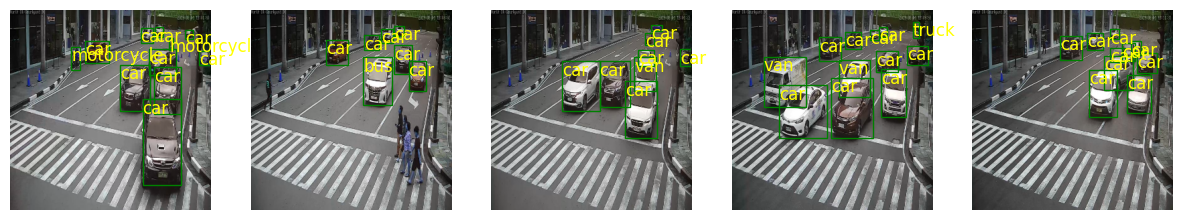

In [ ]:
display_row_of_images_with_bboxes(test_images, test_bboxes, test_labels)

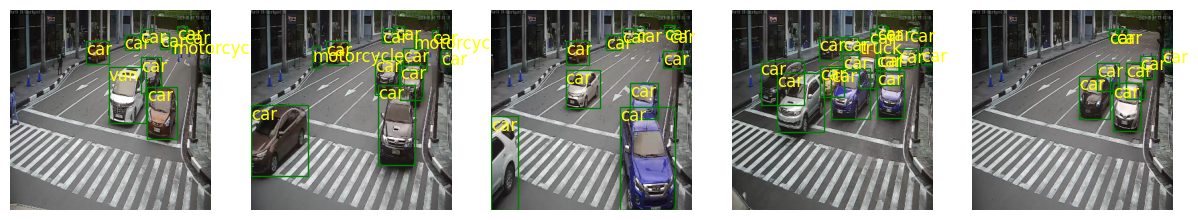

In [ ]:
display_row_of_images_with_bboxes(valid_images, valid_bboxes, valid_labels)